# Experiment: Python vs R Linear Regression Comparison

Is there a Difference between `scikit-learn`'s linear regression fit and R's `lm` fit?

I heard there was, but in the spirit of being a good scientist I'll investigate the claim myself.

## 1. Import Packages and Define Functions

This code section will initiliaze the tools that we will use to investigate this difference.

In [1]:
import rpy2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from rpy2 import robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from multiprocessing import Process, Manager
from psutil import cpu_count

The `wakefield` package from R will be used to generate datasets that will serve as the training data for our regression models.  These datasets will be mock student grades, where the dependent variable will the be their third test grade.

In [2]:
wakefield = importr('wakefield')

robjects.r('''
    generate_dataset <- function(n) {
        # This function generates a new dataset for students' grades.
        #
        # Args:
        #    n: The number of observations in the resulting dataset
        #
        # Returns:
        #    A tibble object for the newly generated dataset
        
        new_dataset <- wakefield::r_data_frame(n,
                                               iq,
                                               age(x = 14:19),
                                               sex,
                                               study_hrs = rnorm(mean = 3),
                                               sat,
                                               grade(name = 'grade1'),
                                               grade(name = 'grade2'),
                                               grade(name = 'grade3'))
        return(new_dataset)
    }
    ''')

R object with classes: ('function',) mapped to:
<SignatureTranslatedFunction - Python:0x7fbad78aa288 / R:0x560099cfa8a8>

The following functions will be used to conduct this experiment.

In [3]:
def convert_rpy2(dataframe):
    '''Convert the R/rpy2 DataFrame to a full pandas dataframe.
    
    Args:
        dataframe: The R/rpy2 Dataframe object.
        
    Returns:
        The input dataframe as a pandas.core.frame.DataFrame object. 
        
    '''
    # Create a dictionary object for each column of the rpy2 dataframe
    columns = list(dataframe.colnames)
    data_values = {col:list(dataframe[i]) for i,col in enumerate(columns)}
    
    # Use the dictionary to create the pandas dataframe
    result_df = pd.DataFrame.from_dict(data_values)
    
    # Re-label encode the values for the sex feature
    # male: 0
    # female: 1
    result_df.Sex = result_df.Sex.map({2:1, 1:0})
    
    return result_df


def R_fit_lm(dataframe):
    '''Call the lm method in R to fit the training dataframe with a 
       linear regression model.
       
       Args:
           dataframe: The training R/rpy2 Dataframe object
       
       Returns:
           A tuple of the beta coefficients of the linear regression
    '''
    stats = importr('stats')
    linreg = stats.lm('grade3 ~ .', data = dataframe)
    
    return tuple(linreg[0][1:])


def py_fit_lm(dataframe):
    '''Use scikit-learn's linear regression model to fit the data.
    
    Args:
        dataframe: The training data that will be fit.
    
    Returns:
        A tuple of the beta coefficients of the linear regression

    '''
    # Split the data into X and y subsets
    X = dataframe.iloc[:, :-1].values
    y = dataframe.iloc[:, 7:].values
    
    # Fit the data using the linear regression
    linreg = LinearRegression()
    linreg.fit(X, y)
    
    # Return the beta coefficients of the trained model
    return tuple(linreg.coef_[0])


def experiment(dataset_count, n_observations, results, pid):
    '''This function encapsulates all the steps required to carry
       out the experiment of testing the beta-coefficient differences
       in the linear regression models created by scikit-learn and lm.
       
       Args:
           dataset_count: The number of datasets to generate
           n_observations: The number of observations in each dataset
           results: The list to which the differences between 
                    beta-coefficients will be appended.
           pid: The process id number
      
       Returns:
           The input beta_coeff_diff array appended with the newly calculated
           values gathered from the current experiment.
           
    '''
    for _ in range(dataset_count):
        # Generate a dataset with the desired number of observations
        gendata = robjects.globalenv['generate_dataset']
        df = gendata(n_observations)
        
        # Compute the beta-coefficients using each programming language
        R_coefficients = R_fit_lm(df)
        py_coefficients = py_fit_lm(convert_rpy2(df))

        differences = np.subtract(R_coefficients, py_coefficients)
        
        # Collect all differences in beta-coefficient values
        for coeff in differences:
            results.append(coeff)

## 2. Fit Many Linear Regressions

We will generate a lot of datasets and for each one fit a linear regression model using both `scikit-learn` in Python and `lm` in R.

To help with compute times, these experiments will be run in parallel by utilizing multiprocessing.

In [4]:
# How many models should we fit?
number_of_datasets = 300

# Split model fitting workload across available CPU cores
available_cores = cpu_count() - 1
ds_per_process = int(number_of_datasets / available_cores)

# Number of observations for each dataset
n = 20200

if __name__ == '__main__':
    manager = Manager()
    processes = []
    # Create a list that will be shared between processes
    results = manager.list()

    # Initiliaze the processes with their assigned experiment tasks & parameters
    for pid in range(available_cores):
        # Run experiment on all processes
        p = Process(target=experiment, args=(ds_per_process, n, results, pid))
        p.start()
        processes.append(pid)

    # Aggregate the results from each process
    for proc in processes:
        p.join()

By investigating the maximum beta coefficient difference value we can observe what the greatest discrepancy was between these programming approaches.

In [5]:
max(results)

2.0218202112509687e-15

The largest observed difference is on the $10^{-15}$ scale, which is very small.

## 3. Discuss Results

The differences in beta coefficient values appear to be academic only.  In other words, our linear regression models from Python and R are in agreement.

We can take a look at the distribution of beta coefficient differences collected from all our fit models.

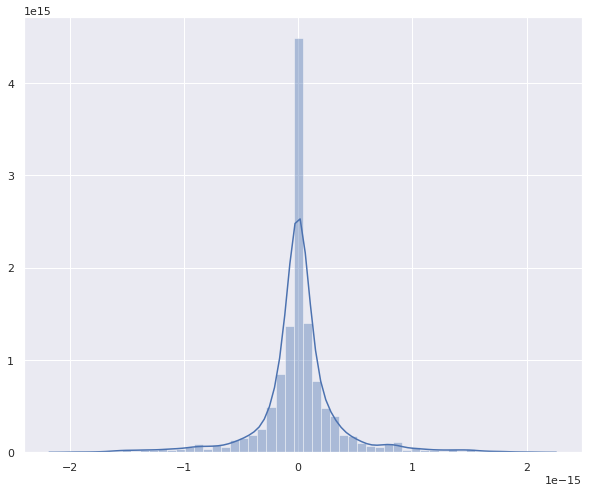

In [6]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(10,8)})
sns.distplot(results);

Our results produce a markedly logistic distribution with a high degree of kurtosis.  However, it is important to note the scale.

This histogram's plot is on the $10^{-15}$ scale.  This, in effect, means there is no difference between the linear models produced by Python or R.

## 4. Conclusion

The results from this experiment are evidence to suggest that there is no effective difference between the linear regression model's produced by `scikit-learn` in Python or `lm` in R.  

These results suggest that you can rest at ease when deciding which package/programming language to build your linear regression model in, because both `scikit-learn` and `lm` will give you the same thing.  Pick whichever language will make your life easier.